# Imports para rodar Pyspark

In [1]:
!pip install pyspark

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [3]:
# Iniciando sessão spark
spark = (
    SparkSession.builder
        .appName('nathan_data_master_v0')
        .config("spark.driver.memory", "8g")  # Ajuste para até 6g se precisar, dependendo do seu uso
        .config("spark.executor.memory", "20g") # Equilibrar a memória do executor
        .config("spark.executor.cores", "4") # O Kaggle geralmente oferece 2 CPUs
        .config("spark.sql.shuffle.partitions", "400") # Ajuste para otimizar o shuffle, depende do dataset
        .config("spark.driver.maxResultSize", "2g")
        .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR") 

spark

# Members

## Visão inic

In [21]:
members = spark.read.parquet('members.parquet')

Verificação de Duplicatas por anomes

In [29]:
members.groupBy('safra').agg(
    (F.count('msno')),
    (F.countDistinct('msno'))
).orderBy('safra').show()

+------+-----------+--------------------+
| safra|count(msno)|count(DISTINCT msno)|
+------+-----------+--------------------+
|201601|    4294184|             4294184|
|201602|    4502354|             4502354|
|201603|    4697972|             4697972|
|201604|    4876301|             4876301|
|201605|    5060705|             5060705|
|201606|    5250064|             5250064|
|201607|    5439337|             5439337|
|201608|    5615921|             5615921|
|201609|    5778986|             5778986|
|201610|    5949288|             5949288|
|201611|    6114345|             6114345|
|201612|    6287789|             6287789|
+------+-----------+--------------------+



Verificação de Nullos por coluna

In [193]:
nulos_por_coluna = members.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in members.columns])

In [195]:
nulos_por_coluna.show()

+----+-----+----------------------+----+---+--------+--------------+--------+
|msno|safra|registration_init_time|city| bd|  gender|registered_via|is_ativo|
+----+-----+----------------------+----+---+--------+--------------+--------+
|   0|    0|                     0|   0|  0|38210177|             0|       0|
+----+-----+----------------------+----+---+--------+--------------+--------+



In [33]:
from pyspark.sql.functions import to_date, date_format

In [35]:
members = members.withColumn("data_registro", F.to_date(members["registration_init_time"], "yyyyMMdd")).drop('registration_init_time')

In [39]:
members.select(
    (F.max('data_registro')).alias('ultimo_registro'),
    (F.min('data_registro')).alias('primeiro_registro')
).show()

+---------------+-----------------+
|ultimo_registro|primeiro_registro|
+---------------+-----------------+
|     2016-12-31|       2004-03-26|
+---------------+-----------------+



## Tratamento da coluna de idade

Verifica Idades Negativas

In [197]:
(members
 .select(F.col('bd').cast('int').alias('idade'))
    .filter(F.col('idade') <= 0)
).count()

39512942

In [25]:
membros = (members
 .select(F.col('bd').cast('int').alias('idade'))
    .filter(
        (F.col('idade') > 18) & (F.col('idade') <= 80)
    )
)

In [27]:
membros.count()

21871833

22MM com idades válidas

Deixando apenas idades Válidas

In [70]:
id_valid = membros.filter( (F.col('idade')>=18) & (F.col('idade') <=80) ) 

In [72]:
mediana = id_valid.approxQuantile("idade", [0.5], 0.01)[0]

In [73]:
mediana

28.0

Colocando a mediana para os outliers de idade

In [79]:
membros = (members
           .withColumn('idade', F.col('bd').cast('int').alias('idade'))
           .withColumn('idade_corrigida', 
                       F.when( (F.col("idade")<18) | (F.col('idade')>80), mediana ).otherwise(F.col('idade'))
                      )
)

Verificando Distribuição da Idade tratada

In [81]:
membros.select('idade_corrigida').summary().show()

+-------+-----------------+
|summary|  idade_corrigida|
+-------+-----------------+
|  count|         63867246|
|   mean|28.87327061198161|
| stddev| 6.04387340872599|
|    min|             18.0|
|    25%|             28.0|
|    50%|             28.0|
|    75%|             28.0|
|    max|             80.0|
+-------+-----------------+



# user_logs

## Total Secs

* Tratando outliers de tempo total escutado
* Tempo negativo
* Tempo total acima da quantidade de segundos em um mês

In [13]:
user_logs.filter(F.col('total_secs') < 0).count()

42346

In [66]:
user_logs.filter(F.col('total_secs') > 2678.400).count()

1650

Tratando outliers por distancia interquartil

In [97]:
log = user_logs.filter(F.col('total_secs').between(0, 2678400))

In [99]:
q1 = log.select('total_secs').approxQuantile("total_secs", [0.25], 0.01)[0]

In [100]:
q3 = log.select('total_secs').approxQuantile("total_secs", [0.75], 0.01)[0]

In [101]:
IQR = q3 - q1

Setando o limite inferior como zero pois não tem tempo negativo

In [111]:
limite_inferior = 0

In [113]:
limite_superior = q3 + 1.5 * IQR

In [115]:
mediana = user_logs.approxQuantile("total_secs", [0.5], 0.01)[0]
mediana

57457.439

In [69]:
log_ajustado = (user_logs
            .withColumn('tempo_total', 
                       F.when( (F.col("total_secs")< 0), 0)
                        .when( (F.col("total_secs")> limite_superior), mediana)
                        .otherwise(F.col('total_secs'))
                      )
)

Verificando a distribuição 

In [75]:
log_ajustado.select('tempo_total').summary().show()

+-------+------------------+
|summary|       tempo_total|
+-------+------------------+
|  count|          26758971|
|   mean| 78328.06169187275|
| stddev| 83260.74411060495|
|    min|               0.0|
|    25%|         11021.553|
|    50%|         57457.439|
|    75%|116691.65599999999|
|    max|        360256.619|
+-------+------------------+



In [55]:
user_logs = spark.read.parquet('user_logs.parquet')

In [59]:
limite_superior = 360256.627

In [61]:
mediana = 57457.439

In [65]:
user_logs_t = (user_logs
    .withColumn('tempo_total', 
                       F.when( (F.col("total_secs")< 0), 0)
                        .when( (F.col("total_secs")> limite_superior), mediana)
                        .otherwise(F.col('total_secs'))
                      )
    .drop('total_secs')
)

# Trata e Junta Bases

In [423]:
members = spark.read.parquet('members.parquet')
user_logs = spark.read.parquet('user_logs.parquet')
transactions = spark.read.parquet('transactions.parquet')

* Tratamento de datas
* Tratamento de outliers para idade
* Criação da target

In [425]:
# média de idade para tratar outliers
mediana = 28

# particiona a base por id e safra
part_clie = Window.partitionBy("msno").orderBy("safra")

members_t = (members

    # trata as datas
    .withColumn("data_registro", F.to_date(members["registration_init_time"], "yyyyMMdd"))
    .withColumn("safra_date", F.to_date(F.concat(F.col("safra").substr(1, 4), F.lit("-"), F.col("safra").substr(5, 2), F.lit("-01")), "yyyy-MM-dd"))

    #criação de feature diferença de dias entre o registro e a data atual
    .withColumn("delta_registro", F.datediff(F.col("safra_date"), F.col("data_registro")))

    #trata outliers de idade
    .withColumn('idade', 
                       F.when( (F.col("bd").cast('int')<18) | (F.col('bd').cast('int')>80), mediana ).otherwise(F.col('bd'))
                      )

     # Tratamento da safra m3 para criação da target        
    .withColumn("safra_m3_date", F.add_months(F.col("safra_date"), 3))
    .withColumn("safra_m3", F.date_format(F.col("safra_m3_date"), "yyyyMM")) 
    .withColumn("is_ativo_safra_m3", 
                  F.when(F.col("safra_m3") == F.lead("safra", 3).over(part_clie), F.lead("is_ativo", 3).over(part_clie))
                   .otherwise(F.lit(0)))
           
    # Criação da target
    .withColumn('target', F.when(
          (F.col('is_ativo') == 1) &
          (F.col('is_ativo_safra_m3') == 0), 1
          ).otherwise(0)
                 )
     # Filtra só o periodo com target   
    .filter(F.col('safra')<=201609)

    # Retira colunas dispensáveis para o uso
    .drop('registration_init_time', 'bd', 'gender')
    .withColumnRenamed('safra_date','safra_dia')
          )

In [427]:
transactions_t = (transactions

    # Tratamento de datas
    .withColumn("data_expira_cadastro", F.to_date(transactions["membership_expire_date"], "yyyyMMdd"))
    .withColumn("data_trasaction", F.to_date(transactions["transaction_date"], "yyyyMMdd"))
    .withColumn("safra_dia", F.to_date(F.concat(F.col("safra").substr(1, 4), F.lit("-"), F.col("safra").substr(5, 2), F.lit("-01")), "yyyy-MM-dd"))
    
    # Criação de Features
    .withColumn("delta_exp_cad", F.datediff(F.col("data_expira_cadastro"), F.col("safra_dia")))
    .withColumn("delta_trasac", F.datediff(F.col("data_trasaction"), F.col("safra_dia")))
    .withColumn("prob_renov_auto", F.avg("is_auto_renew").over(window_3m))
    .withColumn("atraso_pagamento",F.when(F.col("transaction_date") > F.col("membership_expire_date"), 1).otherwise(0))

    # Filtrando apenas o periodo com target
    .filter(
        (F.col('safra')>='201601') &
        (F.col('safra')<='201609')
    )

                 )

In [353]:
rolling_window = Window.partitionBy("msno").orderBy("safra").rowsBetween(-2, 0)
part_clie = Window.partitionBy("msno").orderBy('safra')

In [429]:
limite_superior = 360256.627
mediana = 57457.439
user_logs_t = (user_logs

    #filtrando apenas data que tenho target
    .filter(
        (F.col('safra')>='201601') &
        (F.col('safra')<='201609')
    )

    #tratamento de outliers 
    .withColumn('tempo_total', 
                       F.when( (F.col("total_secs")< 0), 0)
                        .when( (F.col("total_secs")> limite_superior), mediana)
                        .otherwise(F.col('total_secs'))
                      )

    # tratamento de data
    .withColumn("safra_dia", F.to_date(F.concat(F.col("safra").substr(1, 4), F.lit("-"), F.col("safra").substr(5, 2), F.lit("-01")), "yyyy-MM-dd"))



    # Criação de Features
               
    # Adicionar colunas com a média móvel para cada métrica
    .withColumn("media_3m_25", F.avg("num_25").over(rolling_window))
    .withColumn("media_3m_50", F.avg("num_50").over(rolling_window))
    .withColumn("media_3m_75", F.avg("num_75").over(rolling_window))
    .withColumn("media_3m_985", F.avg("num_985").over(rolling_window))
    .withColumn("media_3m_100", F.avg("num_100").over(rolling_window))
    .withColumn("media_3m_unq", F.avg("num_unq").over(rolling_window))

    # divisao entre primeiro mes e atual para captura de tendência
    .withColumn("p_25", F.first("num_25").over(part_clie))
    .withColumn("u_25", F.last("num_25").over(part_clie))
    .withColumn("dif_25", F.col("u_25") / F.col("p_25"))
               
    .withColumn("p_50", F.first("num_50").over(part_clie))
    .withColumn("u_50", F.last("num_50").over(part_clie))
    .withColumn("dif_50", F.col("u_50") / F.col("p_50"))
               
    .withColumn("p_75", F.first("num_75").over(part_clie))
    .withColumn("u_75", F.last("num_75").over(part_clie))
    .withColumn("dif_75", F.col("u_75") / F.col("p_75"))
               
    .withColumn("p_985", F.first("num_985").over(part_clie))
    .withColumn("u_985", F.last("num_985").over(part_clie))
    .withColumn("dif_985", F.col("u_985") / F.col("p_985"))
               
    .withColumn("p_100", F.first("num_100").over(part_clie))
    .withColumn("u_100", F.last("num_100").over(part_clie))
    .withColumn("dif_100", F.col("u_100") / F.col("p_100"))
               
    .withColumn("p_unq", F.first("num_unq").over(part_clie))
    .withColumn("u_unq", F.last("num_unq").over(part_clie))
    .withColumn("dif_unq", F.col("u_unq") / F.col("p_unq"))           
).drop("p_25","u_25","p_50","u_50","p_75","u_75","p_985","u_985","p_100","u_100","p_unq","u_unq",'total_secs')

Junta tudo em uma base final

In [431]:
master = (members_t
.join(transactions_t, ['msno', 'safra', 'safra_dia'], 'left')
.join(user_logs_t, ['msno', 'safra', 'safra_dia'], 'left')
)

Retira quem tem todas as colunas nulas

In [437]:
lista_colunas = [
'payment_method_id',
 'payment_plan_days',
 'plan_list_price',
 'actual_amount_paid',
 'is_auto_renew',
 'transaction_date',
 'membership_expire_date',
 'is_cancel',
 'data_expira_cadastro',
 'data_trasaction',
 'delta_exp_cad',
 'delta_trasac',
 'prob_renov_auto',
 'atraso_pagamento',
 'num_25',
 'num_50',
 'num_75',
 'num_985',
 'num_100',
 'num_unq',
 'tempo_total',
 'media_3m_25',
 'media_3m_50',
 'media_3m_75',
 'media_3m_985',
 'media_3m_100',
 'media_3m_unq',
 'dif_25',
 'dif_50',
 'dif_75',
 'dif_985',
 'dif_100',
 'dif_unq']

In [439]:
condicao = " OR ".join([f"{coluna} IS NOT NULL" for coluna in lista_colunas])

In [441]:
master_t = master.filter(condicao)

Métricas da base final

In [443]:
master_t.count()
# 10.413.790

10413790

In [188]:
master_t.groupBy('target').count().show()

+------+-------+
|target|  count|
+------+-------+
|     0|9316362|
|     1|1097428|
+------+-------+



In [147]:
print('Porcentagem de target na base:',round((1097428/(9316362+1097428))*100, 2),'%')

Porcentagem de target na base: 10.54 %


amostragem da base

In [445]:
tamanho_necessario = 300000
total_linhas = master_t.count()
fração = tamanho_necessario / total_linhas

# Selecionando a amostra aleatória com o seed para garantir que seja sempre a mesma
amostra = master_t.sample(fraction=fração, seed=42)

In [446]:
amostra.toPandas().to_csv(f"C:/Users/natha/master_amostra_tratada2.csv", index=False)
print(f'parte master salva')

parte master salva


# Base Unida

In [455]:
amostra = spark.read.csv("master_amostra_tratada2.csv", header=True, inferSchema=True)

In [598]:
amostra.groupBy('safra').agg( F.round((F.avg('target'))*100,2).alias('% média target') ).orderBy('safra').show()

+------+--------------+
| safra|% média target|
+------+--------------+
|201601|         15.36|
|201602|         15.95|
|201603|         11.29|
|201604|          7.41|
|201605|          8.41|
|201606|          7.95|
|201607|          8.33|
|201608|          9.95|
|201609|         10.22|
+------+--------------+



In [463]:
df = amostra.toPandas()

In [467]:
df.isna().sum()

msno                           0
safra                          0
safra_dia                      0
city                           0
registered_via                 0
is_ativo                       0
data_registro                  0
delta_registro                 0
idade                          0
safra_m3_date                  0
safra_m3                       0
is_ativo_safra_m3              0
target                         0
payment_method_id         108070
payment_plan_days         108070
plan_list_price           108070
actual_amount_paid        108070
is_auto_renew             108070
transaction_date          108070
membership_expire_date    108070
is_cancel                 108070
data_expira_cadastro      108070
data_trasaction           108070
delta_exp_cad             108070
delta_trasac              108070
prob_renov_auto           108070
atraso_pagamento          108070
num_25                     22086
num_50                     22086
num_75                     22086
num_985   

In [477]:
amostra2 = amostra.fillna(-1).fillna('-1').drop('delta_exp_cad')
df2 = amostra2.toPandas()

# Divisao Treino e Teste

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

In [519]:
X = df2.drop(columns=['target'])

In [521]:
y = df2['target']

In [523]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [535]:
X_train.to_csv(f"C:/Users/natha/X_train.csv", index=False)
X_test.to_csv(f"C:/Users/natha/X_test.csv", index=False)
y_train.to_csv(f"C:/Users/natha/y_train.csv", index=False)
y_test.to_csv(f"C:/Users/natha/y_test.csv", index=False)

In [10]:
X_train = pd.read_csv("C:/Users/natha/X_train.csv")  
X_test = pd.read_csv("C:/Users/natha/X_test.csv") 
y_train = pd.read_csv("C:/Users/natha/y_train.csv") 
y_test = pd.read_csv("C:/Users/natha/y_test.csv") 

# One Hot Encoder

In [15]:
!pip install category_encoders
from category_encoders.one_hot import OneHotEncoder

Verificação da quantidade de valores unicos

In [155]:
X_train['registered_via'].nunique()

6

In [15]:
enc = OneHotEncoder(cols=['registered_via'], use_cat_names=True)
enc.fit(X_train)

OneHotEncoder(cols=['registered_via'], use_cat_names=True)

In [17]:
X_train_1 = enc.transform(X_train)

In [19]:
X_test_1  = enc.transform(X_test)

# Target Encoding

In [21]:
from category_encoders.target_encoder import TargetEncoder

In [23]:
enc = TargetEncoder(cols=['city', 'payment_method_id'],min_samples_leaf=200)

In [25]:
enc.fit(X_train_1, y_train)
X_train_2 = enc.transform(X_train_1)

In [27]:
X_test_2 = enc.transform(X_test_1)

In [29]:
X_train_2.to_csv(f"C:/Users/natha/X_train_t.csv", index=False)
X_test_2.to_csv(f"C:/Users/natha/X_test_t.csv", index=False)

# Busca dos melhores Parametros por Randomized Search

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, make_scorer
import numpy as np
from scipy.stats import randint, uniform
from scipy.stats import ks_2samp

In [9]:
X_train = pd.read_csv("C:/Users/natha/X_train_t.csv")  
X_test = pd.read_csv("C:/Users/natha/X_test_t.csv") 
y_train = pd.read_csv("C:/Users/natha/y_train.csv") 
y_test = pd.read_csv("C:/Users/natha/y_test.csv") 

In [11]:
features=['city',
 'registered_via_3.0',
 'registered_via_7.0',
 'registered_via_4.0',
 'registered_via_9.0',
 'registered_via_13.0',
 'registered_via_10.0',
 'delta_registro',
 'idade',
 'payment_method_id',
 'payment_plan_days',
 'plan_list_price',
 'actual_amount_paid',
 'is_auto_renew',
 'delta_trasac',
 'prob_renov_auto',
 'atraso_pagamento',
 'num_25',
 'num_50',
 'num_75',
 'num_985',
 'num_100',
 'num_unq',
 'tempo_total',
 'media_3m_25',
 'media_3m_50',
 'media_3m_75',
 'media_3m_985',
 'media_3m_100',
 'media_3m_unq',
 'dif_25',
 'dif_50',
 'dif_75',
 'dif_985',
 'dif_100',
 'dif_unq']

In [13]:
import time  # Para medir o tempo
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import randint
import numpy as np

# Garantindo que y_train seja 1D
if isinstance(y_train, np.ndarray):
    y_train_fixed = y_train.ravel()  # Para arrays numpy
else:
    y_train_fixed = np.array(y_train).ravel()  # Para pandas DataFrame ou Series

In [15]:
# Definição dos hiperparâmetros para RandomizedSearchCV
param_dists = {
    'n_estimators': randint(30, 500),  
    'max_depth': randint(1, 10),  
    'min_samples_split': randint(100, 500),  
    'min_samples_leaf': randint(100, 500),  
    'criterion': ['gini', 'entropy', 'log_loss']
}

# Instancia o RandomizedSearchCV
rand = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_dists,
    n_iter=10, # numero de interações
    cv=5, # numero de folds para validação cruzada
    scoring='roc_auc', # métrica alvo 
    random_state=42,  # garantindo reprodutibilidade
    verbose=2,
    n_jobs=-1,
    return_train_score=True  # Inclui os scores do treino nos resultados
)

rand.fit(X_train[features], y_train_fixed)  
# Exibindo os resultados
print(f"Melhores parâmetros: {rand.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores parâmetros: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 373, 'min_samples_split': 487, 'n_estimators': 118}


In [16]:
# Convertendo os resultados para DataFrame
cv_results_df = pd.DataFrame(rand.cv_results_)

# Selecionando apenas as colunas de interesse
columns_to_display = [
    'mean_test_score',  # AUC médio no conjunto de teste
    'mean_train_score', # AUC médio no conjunto de treino
    'rank_test_score',  # Rank dos parâmetros com melhor desempenho
    'params'            # Parâmetros testados
]

# Exibindo o DataFrame com as colunas selecionadas
cv_results_df = cv_results_df[columns_to_display]

# Configurando o pandas para exibir as colunas de parâmetros completamente
pd.set_option('display.max_colwidth', None)

In [27]:
cv_results_df.sort_values(['rank_test_score'])

,mean_test_score,mean_train_score,rank_test_score,params
9,0.835407,0.839304,1,"{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 373, 'min_samples_split': 487, 'n_estimators': 118}"
2,0.835364,0.840425,2,"{'criterion': 'log_loss', 'max_depth': 8, 'min_samples_leaf': 472, 'min_samples_split': 199, 'n_estimators': 389}"
3,0.832255,0.834932,3,"{'criterion': 'log_loss', 'max_depth': 6, 'min_samples_leaf': 408, 'min_samples_split': 357, 'n_estimators': 373}"
4,0.829997,0.832826,4,"{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 485, 'min_samples_split': 291, 'n_estimators': 473}"
1,0.828403,0.830235,5,"{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 202, 'min_samples_split': 221, 'n_estimators': 496}"
0,0.819566,0.820687,6,"{'criterion': 'log_loss', 'max_depth': 4, 'min_samples_leaf': 448, 'min_samples_split': 370, 'n_estimators': 136}"
8,0.810416,0.811506,7,"{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 406, 'min_samples_split': 234, 'n_estimators': 50}"
7,0.808824,0.809509,8,"{'criterion': 'log_loss', 'max_depth': 3, 'min_samples_leaf': 463, 'min_samples_split': 154, 'n_estimators': 273}"
5,0.741955,0.742211,9,"{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 413, 'min_samples_split': 121, 'n_estimators': 282}"
6,0.741181,0.741487,10,"{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 158, 'min_samples_split': 269, 'n_estimators': 217}"


# Roda Modelo com os melhores parametros

In [36]:
rf = RandomForestClassifier(
    class_weight='balanced',
    criterion='gini',
    max_depth=7,
    min_samples_leaf=373,
    min_samples_split=487,
    n_estimators=118,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rf.fit(X_train[features], y_train_fixed)  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    4.7s finished


RandomForestClassifier(class_weight='balanced', max_depth=7,
                       min_samples_leaf=373, min_samples_split=487,
                       n_estimators=118, n_jobs=-1, random_state=42, verbose=1)

## Verifica Métricas no Treino e no Teste

In [61]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

from scipy.stats import ks_2samp

# Função para calcular o KS
def calculate_ks(y_true, y_prob):
    # Criando um DataFrame para manipulação
    df = pd.DataFrame({'real': y_true, 'probabilidade': y_prob})
    # Separando as probabilidades por classe
    prob_positivos = df[df['real'] == 1]['probabilidade']
    prob_negativos = df[df['real'] == 0]['probabilidade']
    # Calculando o KS com ks_2samp
    ks_stat, _ = ks_2samp(prob_positivos, prob_negativos)
    return ks_stat

In [67]:
y_test_values = y_test['target'].values  
y_train_values = y_train['target'].values

y_train_prob = rf.predict_proba(X_train[features])[:, 1]  # Probabilidade da classe positiva (1) no treino
y_test_prob = rf.predict_proba(X_test[features])[:, 1]    # Probabilidade da classe positiva (1) no teste

y_pred_train = rf.predict(X_train[features])
y_pred_test = rf.predict(X_test[features])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 118 out of 118 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 118 out of 118 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 118 out of 118 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 118 out of 118 | elapsed:    0.0s finished


In [69]:
# Calcular AUC no treino
auc_train = roc_auc_score(y_train, y_train_prob)
# Calculando o KS no treino
ks_treino = calculate_ks(y_train_values, y_train_prob)

# Calcular AUC no teste
auc_test = roc_auc_score(y_test, y_test_prob)
# Calculando o KS no teste
ks_teste = calculate_ks(y_test_values, y_test_prob)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)


# Exibindo os valores
print(f"AUC no treino: {auc_train:.3f}")
print(f"AUC no teste: {auc_test:.3f}")
print('-'*20)
print(f"KS no treino: {ks_treino:.3f}")
print(f"KS no teste: {ks_teste:.3f}")
print('-'*20)
print(f"accuracy no treino: {accuracy_train:.3f}")
print(f"accuracy no teste: {accuracy_test:.3f}")

AUC no treino: 0.839
AUC no teste: 0.833
--------------------
KS no treino: 0.522
KS no teste: 0.514
--------------------
accuracy no treino: 0.709
accuracy no teste: 0.708


In [31]:
X_train = pd.read_csv("C:/Users/natha/X_train_t.csv")  
X_test = pd.read_csv("C:/Users/natha/X_test_t.csv") 
y_train = pd.read_csv("C:/Users/natha/y_train.csv") 
y_test = pd.read_csv("C:/Users/natha/y_test.csv") 

In [71]:
importances = rf.feature_importances_

In [78]:
# Criar um DataFrame para visualizar melhor
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

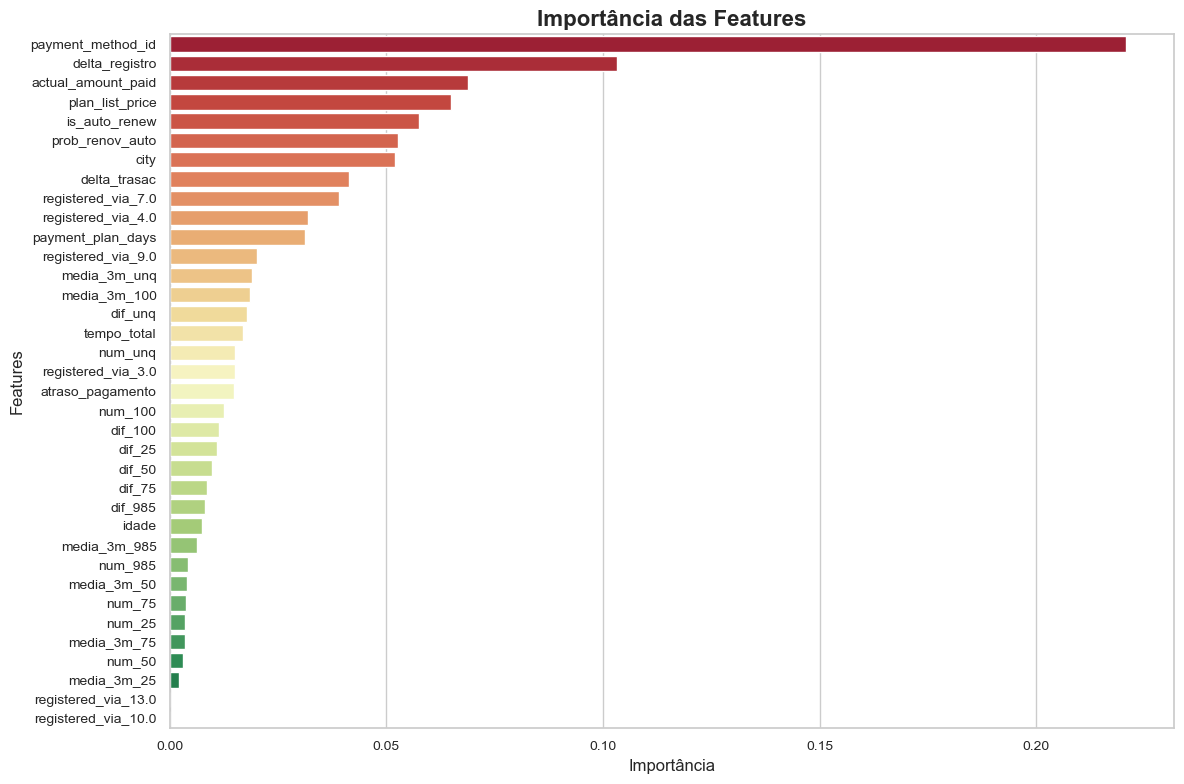

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ordenar o DataFrame pela importância em ordem decrescente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Configurar estilo do Seaborn
sns.set_theme(style="whitegrid")

# Criar o gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df, 
    palette=sns.color_palette("RdYlGn", n_colors=len(feature_importance_df))
)

# Personalizar o gráfico
plt.title("Importância das Features", fontsize=16, fontweight='bold')
plt.xlabel("Importância", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Mostrar o gráfico
plt.show()

# Acha melhor corte função custo

A função de custo (C) é definida por: \
**C = 12 x 0.5 x TP - ( TP + Fp ) x 3**

Onde:
* (TP) é o número de verdadeiro positivos
* (FP) é o número de falsos positivos.

Ganho é 12 meses x 50% vai ficar retido x Churn M3 positivo \
Custo é todos clientes classificados como Churn M3 x 3 meses gratuitos

In [81]:
def custom_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 12*0.5*tp - (tp + fp)*3

In [87]:
# Obter as probabilidades de cada classe usando o modelo
y_proba = rf.predict_proba(X_test[features])  

# Criar as probabilidades de positivo e negativo
proba_negativo = y_proba[:, 0]  # Probabilidade da classe 0
proba_positivo = y_proba[:, 1]  # Probabilidade da classe 1

# Criar o DataFrame com as informações
resultados = pd.DataFrame({
    "y_test": y_test_values,          # Valores reais
    "proba_negativo": proba_negativo,  # Probabilidade para a classe 0
    "proba_positivo": proba_positivo, # Probabilidade para a classe 1
    'y_pred': y_pred_test
})

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 118 out of 118 | elapsed:    0.0s finished


In [95]:
# Inicializar lista para armazenar os resultados de cada threshold
resultados_threshold = []

# Loop para testar diferentes valores de threshold
for threshold in np.arange(0.0, 1.01, 0.01):  # Testa de 0.0 a 1.0 com passos de 0.01
    # Criar a previsão binária com o threshold atual
    resultados["y_pred"] = (resultados["proba_positivo"] >= threshold).astype(int)
    
    # Calcular o custo com a função custom_cost
    custo_atual = custom_cost(resultados["y_test"], resultados["y_pred"])
    
    # Armazenar o resultado do threshold atual
    resultados_threshold.append({"threshold": threshold, "custo": custo_atual})

# Criar um DataFrame com os resultados de todos os thresholds
custos_df = pd.DataFrame(resultados_threshold)

# Identificar o melhor threshold e seu custo associado
melhor_resultado = custos_df.loc[custos_df["custo"].idxmax()]

# Exibir o melhor threshold e custo
print(f"Melhor threshold: {melhor_resultado['threshold']}")
print(f"Melhor custo: {melhor_resultado['custo']}")

# Exibir todos os resultados em ordem decrescente de custo
custos_df.sort_values(by="custo", ascending=False)

Melhor threshold: 0.8300000000000001
Melhor custo: 3630.0


,threshold,custo
83,0.83,3630.0
84,0.84,3609.0
82,0.82,3567.0
85,0.85,3510.0
81,0.81,3342.0
...,...,...
4,0.04,-208500.0
3,0.03,-211473.0
2,0.02,-216204.0
1,0.01,-231519.0


C:\Users\natha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\natha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


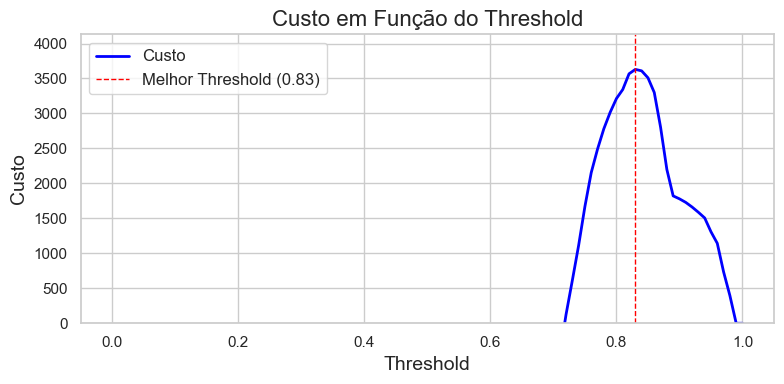

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar estilo do Seaborn
sns.set_theme(style="whitegrid")

# Criar o gráfico
plt.figure(figsize=(8, 4))  # Tamanho da figura
ax = sns.lineplot(x="threshold", y="custo", data=custos_df, color="blue", linewidth=2, label="Custo")

# Destaque para o melhor threshold
melhor_threshold = melhor_resultado["threshold"]
melhor_custo = melhor_resultado["custo"]
plt.axvline(x=melhor_threshold, color="red", linestyle="--", linewidth=1, label=f"Melhor Threshold ({melhor_threshold:.2f})")

# Ajustar limites do eixo Y
plt.ylim(0, custos_df["custo"].max() + 500)

# Adicionar títulos e rótulos
plt.title("Custo em Função do Threshold", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Custo", fontsize=14)

# Legenda
plt.legend(fontsize=12)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

## Clusterização

In [161]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Retira Variáveis Correlacionadas

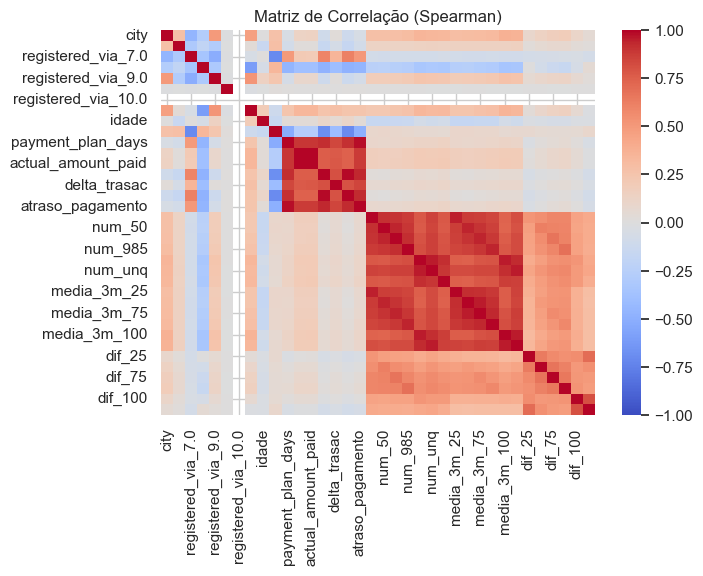

In [131]:
# Calculando a matriz de correlação de Spearman
correlation_matrix = X_test[features].corr(method='spearman')

# Criando o heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Matriz de Correlação (Spearman)")
plt.show()

In [141]:
# Definindo o limite de correlação
threshold = 0.9

# Encontrando pares de variáveis altamente correlacionadas
correlated_pairs = []

for i in range(correlation_matrix.shape[0]):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            col1 = correlation_matrix.index[i]
            col2 = correlation_matrix.columns[j]
            correlated_pairs.append((col1, col2))

# Exibindo os pares de features correlacionadas
print("Pares de features com alta correlação:")
correlated_pairs

Pares de features com alta correlação:


[('actual_amount_paid', 'plan_list_price'),
 ('is_auto_renew', 'payment_plan_days'),
 ('prob_renov_auto', 'payment_plan_days'),
 ('prob_renov_auto', 'is_auto_renew'),
 ('atraso_pagamento', 'payment_plan_days'),
 ('atraso_pagamento', 'is_auto_renew'),
 ('atraso_pagamento', 'prob_renov_auto'),
 ('num_50', 'num_25'),
 ('num_75', 'num_50'),
 ('num_985', 'num_75'),
 ('num_unq', 'num_100'),
 ('tempo_total', 'num_100'),
 ('media_3m_25', 'num_25'),
 ('media_3m_50', 'num_50'),
 ('media_3m_50', 'num_75'),
 ('media_3m_50', 'media_3m_25'),
 ('media_3m_75', 'num_50'),
 ('media_3m_75', 'num_75'),
 ('media_3m_75', 'media_3m_25'),
 ('media_3m_75', 'media_3m_50'),
 ('media_3m_985', 'num_985'),
 ('media_3m_985', 'media_3m_50'),
 ('media_3m_985', 'media_3m_75'),
 ('media_3m_100', 'num_100'),
 ('media_3m_100', 'num_unq'),
 ('media_3m_unq', 'num_100'),
 ('media_3m_unq', 'num_unq'),
 ('media_3m_unq', 'media_3m_100')]

In [143]:
# Criando uma lista para armazenar as features redundantes
redundant_features = set()

for col1, col2 in correlated_pairs:
    redundant_features.add(col2)  # Escolha arbitrária: mantém col1 e remove col2

# Exibindo as features redundantes
print("Features a serem removidas:")
list(redundant_features)

Features a serem removidas:


['num_50',
 'num_unq',
 'plan_list_price',
 'num_25',
 'payment_plan_days',
 'media_3m_25',
 'is_auto_renew',
 'media_3m_100',
 'media_3m_50',
 'num_100',
 'media_3m_75',
 'prob_renov_auto',
 'num_985',
 'num_75']

In [147]:
# Criando uma nova lista sem os nomes a remover
features_sem_corr = [f for f in features if f not in redundant_features]

### Roda Kmeans

In [163]:
# Normaliza as variaveis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_test[features_sem_corr])

In [175]:
import matplotlib.pyplot as plt

distortions = []
K = range(1, 10)  # Testar de 1 a 9 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)

C:\Users\natha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\natha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\natha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\natha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\natha\anaconda3\Lib\site-packages\sklearn\clust

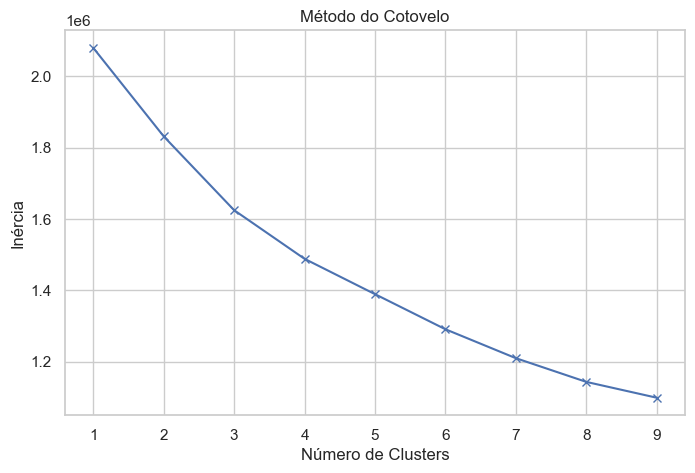

In [176]:
# Plotar o método do cotovelo
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel("Número de Clusters")
plt.ylabel("Inércia")
plt.title("Método do Cotovelo")
plt.show()

In [167]:
k = 3  
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

C:\Users\natha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

### Distribuição da Target por Cluster

In [169]:
# Criar o DataFrame com os clusters e a variável target
resultados = pd.DataFrame({
    "cluster": kmeans.labels_,
    "target": y_test_values
})

In [182]:
# Contar a quantidade de cada valor da target em cada cluster
distribuicao = resultados.groupby(["cluster", "target"]).size().unstack(fill_value=0)
proporcao = distribuicao.div(distribuicao.sum(axis=1), axis=0)

In [184]:
proporcao

target,0,1
cluster,,
0,0.939291,0.060709
1,0.954880,0.045120
2,0.832509,0.167491
